In [8]:
# Imports
import pandas as pd
import numpy as np
import sklearn
from sklearn import pipeline, ensemble
import os

In [20]:
# File Reading and Splitting

# Read files
data = []
labels = []
longest_sample_length = 0

for root, dirpath, files in os.walk("Spectrograms"):
        for folder in dirpath:
            for r, d, files_in_folder in os.walk(os.path.join("Spectrograms", folder)):
                for f in files_in_folder:
                    path = os.path.join(root, folder, f)
                    d = np.load(path)
                    
                    
                    if len(d[1]) > longest_sample_length:
                        longest_sample_length = len(d[1])
                    
                    data.append(d)
                    labels.append(folder)
                    

data_new = []
for i in range(len(data)):
    d = data[i][1]
    num_samp = longest_sample_length // len(d)
    remainder = longest_sample_length % len(d)
    
    temp = []
    for j in range(num_samp):
        temp.extend(d)
    temp.extend(d[:remainder])
    
    data_new.append(temp)

print("Finished converting and padding data")

dx = [data_new, labels]
dx = np.swapaxes(dx, 0, 1)

split2 = 10 / 90
train_val, test = sklearn.model_selection.train_test_split(dx, test_size=0.10, random_state=42)
train, val = sklearn.model_selection.train_test_split(train_val, test_size=split2)

print("Split Complete! Train Size:", len(train), "Validation Size:", len(val), "Test Size:", len(test))

Finished converting and padding data
Split Complete! Train Size: 2374 Validation Size: 297 Test Size: 297


/opt/conda/envs/common/lib/python3.7/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


In [21]:
# Rotate all on axes
train_val = np.swapaxes(train_val, 0, 1)
train = np.swapaxes(train, 0, 1)
val = np.swapaxes(val, 0, 1)

In [22]:
tdf = pd.DataFrame()
vdf = pd.DataFrame()
tvdf = pd.DataFrame()

for i in range(len(train[0])):
    tdf[i] = train[0][i]
for i in range(len(val[0])):
    vdf[i] = val[0][i]
for i in range(len(train_val[0])):
    tvdf[i] = train_val[0][i]

tdf = np.swapaxes(tdf, 0, 1)
vdf = np.swapaxes(vdf, 0, 1)
tvdff = np.swapaxes(tvdf, 0, 1)

tdf.head()

,0,1,2,3,4,5,6,7,8,9,...,163,164,165,166,167,168,169,170,171,172
0,-112.833496,-108.474876,-101.984070,-99.889717,-105.678368,-105.322426,-107.726830,-108.189850,-111.603218,-105.419998,...,-100.648422,-92.565666,-50.639877,-16.048378,-6.180239,-77.818275,-106.416763,-99.696754,-101.013535,-102.716270
1,24.698315,14.715418,-31.502666,-23.843624,-32.176811,-37.559185,-35.798004,-28.446920,-27.895702,-32.486183,...,-33.370552,-27.245541,-24.217360,-29.487993,-26.427158,-27.025913,-29.057621,-28.249733,-26.735081,-27.277821
2,-17.802500,-13.220938,-57.034866,-67.178825,-61.048180,-66.046875,-30.087477,-15.565578,-55.454201,-53.608772,...,1.802675,1.824306,-3.585456,-9.248821,-8.329269,-6.058465,-16.620514,-43.195679,-40.458557,-16.432587
3,-53.923225,-82.695381,-93.734955,-74.396553,-82.325668,-97.158836,-73.379059,-83.386536,-101.038063,-65.377808,...,-73.102524,-88.308907,-73.969711,-94.293442,-95.303078,-62.370667,-83.600166,-91.256195,-67.135605,-50.392391
4,14.142057,-15.860601,-29.198671,-30.664646,-32.035343,-34.715744,-43.247852,-39.254150,-45.023003,-53.445801,...,69.048599,70.677139,64.835777,59.788353,60.539783,60.987869,61.000114,63.521782,63.164101,53.101856


In [23]:
# Shuffling
X_train, y_train = sklearn.utils.shuffle(tdf, train[1])
X_val, y_val = sklearn.utils.shuffle(vdf, val[1])

In [27]:
pipeline = sklearn.pipeline.make_pipeline(sklearn.preprocessing.StandardScaler(), 
                                          sklearn.ensemble.RandomForestClassifier(n_estimators = 1500))

X = X_train
y = y_train

pipeline.fit(X, y)

valpred = pipeline.predict(X_val)
trainpred = pipeline.predict(X_train)

v_acc = sklearn.metrics.accuracy_score(valpred, y_val)
t_acc = sklearn.metrics.accuracy_score(trainpred, y_train)

print("Validation:", v_acc, "Training:", t_acc)

Validation: 0.8114478114478114 Training: 1.0


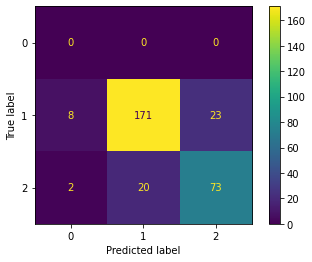

In [25]:
cm = sklearn.metrics.confusion_matrix(valpred, y_val)
cm_plot = sklearn.metrics.ConfusionMatrixDisplay(cm)
cm_plot.plot()

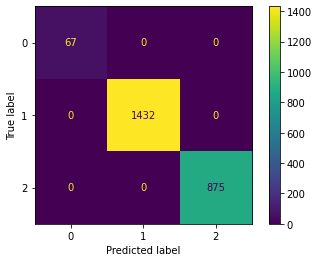

In [26]:
cm = sklearn.metrics.confusion_matrix(trainpred, y_train)
cm_plot = sklearn.metrics.ConfusionMatrixDisplay(cm)
cm_plot.plot()

In [29]:
# Crossvalidation

cv = sklearn.model_selection.cross_validate(pipeline, X, y, cv=5)

print(cv)

{'fit_time': array([26.55666924, 27.4490869 , 27.10295081, 27.32719898, 27.62938404]), 'score_time': array([0.23954916, 0.24080896, 0.24178123, 0.24195814, 0.24026847]), 'test_score': array([0.70105263, 0.74526316, 0.74736842, 0.73894737, 0.7257384 ])}
